In [1]:
import os
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import Model
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = '/content/drive/My Drive/Colab Notebooks/Tensorflow Datasets/BEAN'

In [4]:
train_dir = os.path.join(root, 'train')
valid_dir = os.path.join(root,'validation')
test_dir = os.path.join(root,'test')
print(os.listdir(test_dir))


['angular_leaf_spot', 'bean_rust', 'healthy']


In [5]:
#To extract file names from each directory
def extract_filenames(dir):
  path= os.path.join(root, dir)
  filenames=list()
  labels =list()
  for dir in os.listdir(path):
    for filename in os.listdir(os.path.join(path,dir)):
      filenames.append(os.path.join(path, dir, filename))
      labels.append(dir)
  return filenames, labels


In [6]:
imgs, labels = extract_filenames("train")
print(set(labels))

{'healthy', 'bean_rust', 'angular_leaf_spot'}


Counter({'bean_rust': 348, 'angular_leaf_spot': 345, 'healthy': 342})


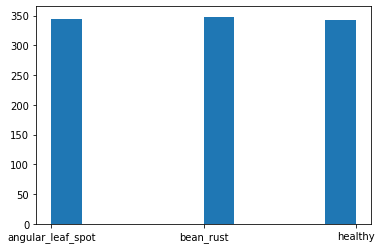

In [7]:
#Plot the labels in the train directory
from collections import Counter
print(Counter(labels))
plt.hist(labels)
plt.show()

In [8]:
train_files, train_labels = extract_filenames(train_dir)
valid_files, valid_labels = extract_filenames(valid_dir)
test_files, test_labels = extract_filenames(test_dir)

Counter({'bean_rust': 436, 'angular_leaf_spot': 432, 'healthy': 428})


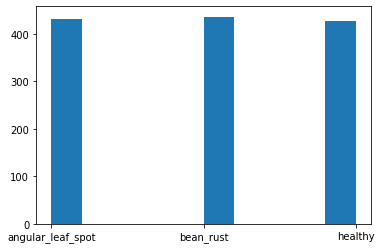

In [9]:
#Plot all labels
all_labels =train_labels+valid_labels+test_labels
print(Counter(all_labels))
plt.hist(all_labels)
plt.show()

In [10]:
#Class names
def names(path):
  for dir, dirnames, filenames in os.walk(path):
    if len(dirnames) != 0:
      class_names= dirnames
  return class_names

classes = names(train_dir)
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


In [11]:
# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0,
                                           mode='auto', baseline=None, restore_best_weights=False )

In [12]:
#class myCallback(tf.keras.callbacks.Callback):
#  def on_epoch_end(self,epoch,logs={}):
#    if(logs.get('accuracy')>0.84):
#      print("\n Reached 84% accurcy so cancelling training!")
#      self.model.stop_training = True

    

In [12]:
train_im_gen = ImageDataGenerator(rescale= 1./255,
                                   zoom_range= 0.2,
                                   rotation_range= 0.4,                                  
                                   width_shift_range= 0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split= 0.0)

validation_im_gen = ImageDataGenerator(rescale=1./255)

test_im_gen = ImageDataGenerator(rescale= 1./255 )



In [13]:
train_datagen= train_im_gen.flow_from_directory(train_dir,
                                             target_size= (300,300),
                                             batch_size=128,
                                             shuffle=True,
                                             class_mode='sparse' )

valid_datagen= validation_im_gen.flow_from_directory(valid_dir ,
                                             batch_size =128,
                                             class_mode='sparse',
                                             target_size= (300,300))
test_datagen = test_im_gen.flow_from_directory(test_dir,
                                               batch_size=128,
                                               class_mode='sparse',
                                               target_size= (300,300)
                                               )


Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


In [14]:
training_images, training_labels = next(train_datagen)

angular_imgs = training_images[training_labels==0][:3]
bean_imgs = training_images[training_labels==1][:3]
healthy_imgs = training_images[training_labels==2][:3]
sample_images = [   
    angular_imgs,
    bean_imgs,
    healthy_imgs,
]

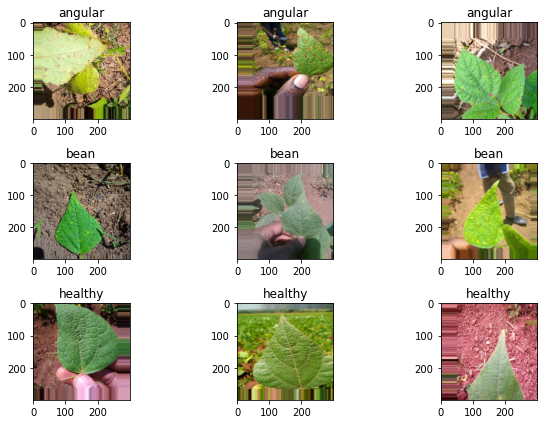

In [15]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(3, 3, figsize=(9,6))
    for row, (label_imgs, label) in enumerate(zip(images_arr, labels)):
        for column, img in enumerate(label_imgs):
            axes[row, column].imshow(img)
            axes[row, column].set_title(label)
    plt.tight_layout()
    #plt.axis('off')
    plt.show()
plotImages(sample_images, ["angular", "bean","healthy"])

In [16]:
#callbacks= myCallback()

In [17]:
# Build the Model

model= tf.keras.Sequential([tf.keras.layers.Conv2D(32,(3,3),padding='same', input_shape=(300,300,3), activation ='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            
                            tf.keras.layers.Conv2D(128,(3,3),padding='same', activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),

                            tf.keras.layers.Conv2D(512, (3,3),padding='same', activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),

                            tf.keras.layers.Dropout(0.4),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(128,activation='relu'),
                            tf.keras.layers.Dense(3, activation='softmax')
                            ])

In [18]:
#Compile Model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Note that SPARSE CATEGORICAL works with integer categorical variable, if you do not specify Softmax, then we should add (from_logits=True)

In [19]:
EPOCHS=50
#Fit the model
history = model.fit(train_datagen, 
          epochs= EPOCHS,
          validation_data = valid_datagen)
          #callbacks = [callback])

Epoch 1/50
9/9 [==============================] - 555s 60s/step - loss: 8.6563 - accuracy: 0.3505 - val_loss: 1.0852 - val_accuracy: 0.3459
Epoch 2/50
9/9 [==============================] - 25s 3s/step - loss: 1.0545 - accuracy: 0.4256 - val_loss: 0.9709 - val_accuracy: 0.5263
Epoch 3/50
9/9 [==============================] - 25s 3s/step - loss: 0.9717 - accuracy: 0.5248 - val_loss: 0.7967 - val_accuracy: 0.6316
Epoch 4/50
9/9 [==============================] - 25s 3s/step - loss: 0.8550 - accuracy: 0.6151 - val_loss: 0.7031 - val_accuracy: 0.7293
Epoch 5/50
9/9 [==============================] - 25s 3s/step - loss: 0.8288 - accuracy: 0.6637 - val_loss: 0.7940 - val_accuracy: 0.6316
Epoch 6/50
9/9 [==============================] - 25s 3s/step - loss: 0.7738 - accuracy: 0.6836 - val_loss: 0.7208 - val_accuracy: 0.7068
Epoch 7/50
9/9 [==============================] - 25s 3s/step - loss: 0.7010 - accuracy: 0.6901 - val_loss: 0.6860 - val_accuracy: 0.6692
Epoch 8/50
9/9 [================

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 128)     36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 512)       590336    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 512)       0

In [21]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

epochs_range= range(EPOCHS)

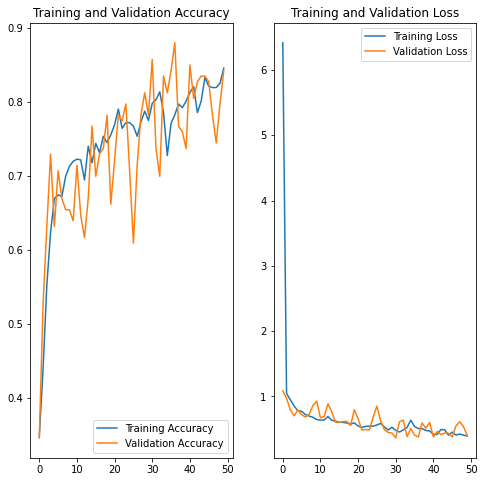

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()


In [23]:
#Evaluate Accuracy
test_loss, test_accuracy  = model.evaluate(test_datagen, batch_size=128)

print('Accuracy on test dataset:', test_accuracy)

1/1 [==============================] - 1s 984ms/step - loss: 0.5373 - accuracy: 0.7969
Accuracy on test dataset: 0.796875


In [24]:
test_images, test_labels = next(test_datagen)
predictions = model.predict(test_images)
predicts =np.argmax(model.predict(test_datagen), axis=-1)
labels= test_labels.astype(int)
print(list((labels)))
print(list(predicts))
print(len(predicts))

[2, 2, 1, 0, 2, 1, 1, 0, 0, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0]
[2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 2, 1, 0, 1, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 0, 1, 2, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0]
128


     |████████████████████████████████| 1.4MB 4.3MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1370643750>)

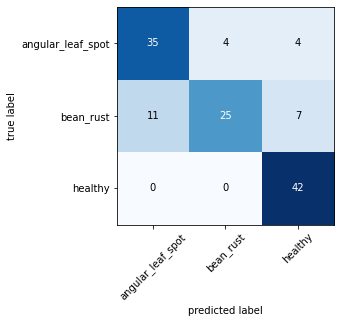

In [25]:
!pip install mlxtend --upgrade --no-deps 
#Confusion Matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

mat =confusion_matrix(test_labels, predicts)
plot_confusion_matrix(conf_mat=mat, class_names= classes)

In [26]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


def plot_image(i, predictions_array, true_label, images):
    predictions_array, true_label, img = predictions_array[i], true_label[i], images[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{}  {:2.0f}% ({})". format(classes[predicted_label], 100*np.max(predictions_array), classes[true_label]),
               color=color)

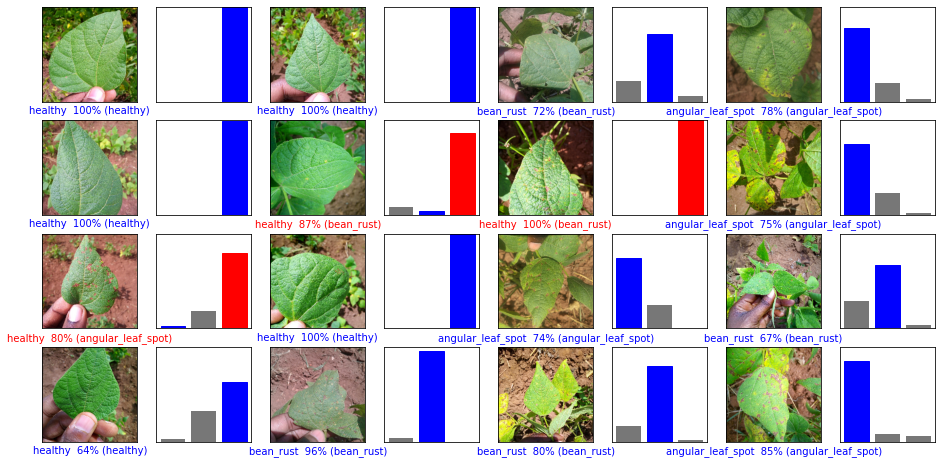

In [27]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, labels)